In [100]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer

In [133]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 20

latent_dim = 12

beta = 1

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [102]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [103]:
def get_target(target_label):
    """
    
    """
    #if target_label == 10:
    t = torch.ones(1)    
    return t.to(device)     
    
    #t = torch.zeros(1)    
    #return t.to(device) 

In [104]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target(x))
)
len(train_data)

60000

In [105]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target(x))
)
len(test_data)

10000

In [106]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

## Model

In [107]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [108]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [109]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        """
        
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        return mu, x_recon
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        return mu, logvar, z
    
    def decoder_pass(self, x):
        return self.decoder(x)


## Обучаем VAE

In [112]:
model = VAE(latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,709,027


VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=24, bias=True)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=12, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Number of parameters: 95,320


CNN_ARATE(
  (arate_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): SiLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): SiLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): SiLU()
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=9216, out_features=3, bias=True)
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fuzzy): Sequential(
    (0): FuzzyLayer()
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): DefuzzyLinearLayer()
  )
)

In [114]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [115]:
def compute_loss(x, recon_x, mu, logvar):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
    
    loss = loss_recon + beta * loss_kl

    return loss, loss_recon, loss_kl
    

In [116]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logvar, z = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
    
        loss, loss_recon, loss_kl = compute_loss(data, recon_x, mu, logvar)
        loss.backward()
                
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('VAE/Train/Loss', loss.item(), global_step)
                writer.add_scalar('VAE/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('VAE/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('VAE/Train/GradNorm', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [117]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logvar, z = model.half_pass(data)  
            recon_x = model.decoder_pass(z)

            loss, loss_recon, loss_kl = compute_loss(data, recon_x, mu, logvar)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f}')
    
    if writer is not None:
        writer.add_scalar('VAE/Test/Loss', test_loss, global_step=cur_step)
        writer.add_scalar('VAE/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('VAE/Test/KLD', loss_kl.item(), global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('VAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [118]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 22.1958 (Recon: 21.1497, KL: 1.0462 Grad: 17.7289
Step 100 (N samples: 25,600), Loss: 7.7385 (Recon: 7.5679, KL: 0.1707 Grad: 9.3159
Step 200 (N samples: 51,200), Loss: 7.2855 (Recon: 6.9214, KL: 0.3641 Grad: 5.2240


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2746 (BCE: 6.7899, KLD: 0.4846
Epoch 2/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.2425 (Recon: 6.6731, KL: 0.5694 Grad: 3.6644
Step 400 (N samples: 102,400), Loss: 7.2008 (Recon: 6.5940, KL: 0.6068 Grad: 2.1643


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2029 (BCE: 6.3474, KLD: 0.8555
Epoch 3/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.0739 (Recon: 6.3179, KL: 0.7561 Grad: 5.5192
Step 600 (N samples: 153,600), Loss: 7.0996 (Recon: 6.3062, KL: 0.7934 Grad: 2.9087
Step 700 (N samples: 179,200), Loss: 6.9744 (Recon: 6.1329, KL: 0.8415 Grad: 1.6967


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0494 (BCE: 6.1871, KLD: 0.8623
Epoch 4/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 6.9452 (Recon: 5.9552, KL: 0.9900 Grad: 6.9404
Step 900 (N samples: 230,400), Loss: 6.9157 (Recon: 5.9658, KL: 0.9499 Grad: 2.4191


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0049 (BCE: 5.9950, KLD: 1.0099
Epoch 5/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.0882 (Recon: 6.1059, KL: 0.9824 Grad: 5.8119
Step 1,100 (N samples: 281,600), Loss: 6.8826 (Recon: 5.8613, KL: 1.0213 Grad: 4.4959


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1213 (BCE: 5.9266, KLD: 1.1946
Epoch 6/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 6.8397 (Recon: 5.8481, KL: 0.9915 Grad: 1.4941
Step 1,300 (N samples: 332,800), Loss: 6.9573 (Recon: 5.9002, KL: 1.0571 Grad: 8.8743
Step 1,400 (N samples: 358,400), Loss: 6.8379 (Recon: 5.8265, KL: 1.0115 Grad: 1.5031


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9392 (BCE: 5.8971, KLD: 1.0421
Epoch 7/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 6.7730 (Recon: 5.6694, KL: 1.1037 Grad: 2.7104
Step 1,600 (N samples: 409,600), Loss: 6.8361 (Recon: 5.7689, KL: 1.0673 Grad: 1.3258


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9364 (BCE: 5.8843, KLD: 1.0521
Epoch 8/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.0493 (Recon: 5.9568, KL: 1.0925 Grad: 6.7601
Step 1,800 (N samples: 460,800), Loss: 6.8746 (Recon: 5.8329, KL: 1.0417 Grad: 2.4830


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9266 (BCE: 5.7589, KLD: 1.1677
Epoch 9/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 6.7094 (Recon: 5.6067, KL: 1.1027 Grad: 2.6096
Step 2,000 (N samples: 512,000), Loss: 6.9382 (Recon: 5.8202, KL: 1.1181 Grad: 3.3946
Step 2,100 (N samples: 537,600), Loss: 6.9282 (Recon: 5.8192, KL: 1.1090 Grad: 1.0987


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9101 (BCE: 5.8289, KLD: 1.0811
Epoch 10/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 6.8088 (Recon: 5.6451, KL: 1.1636 Grad: 1.9371
Step 2,300 (N samples: 588,800), Loss: 6.8232 (Recon: 5.6693, KL: 1.1539 Grad: 2.2914


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8933 (BCE: 5.7831, KLD: 1.1102
Epoch 11/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 6.9619 (Recon: 5.7562, KL: 1.2057 Grad: 1.5122
Step 2,500 (N samples: 640,000), Loss: 7.1188 (Recon: 5.9171, KL: 1.2017 Grad: 1.5187


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8878 (BCE: 5.7350, KLD: 1.1527
Epoch 12/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 6.9134 (Recon: 5.7600, KL: 1.1533 Grad: 0.9750
Step 2,700 (N samples: 691,200), Loss: 6.9764 (Recon: 5.7893, KL: 1.1871 Grad: 1.1915
Step 2,800 (N samples: 716,800), Loss: 6.9937 (Recon: 5.7924, KL: 1.2013 Grad: 1.3124


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9110 (BCE: 5.6259, KLD: 1.2851
Epoch 13/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 6.9033 (Recon: 5.6878, KL: 1.2155 Grad: 1.5629
Step 3,000 (N samples: 768,000), Loss: 6.9315 (Recon: 5.7736, KL: 1.1579 Grad: 1.6247


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8550 (BCE: 5.6695, KLD: 1.1855
Epoch 14/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 6.8604 (Recon: 5.6868, KL: 1.1736 Grad: 1.1821
Step 3,200 (N samples: 819,200), Loss: 6.9284 (Recon: 5.7039, KL: 1.2245 Grad: 1.2094


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9937 (BCE: 5.6396, KLD: 1.3541
Epoch 15/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 6.8386 (Recon: 5.6383, KL: 1.2003 Grad: 2.2256
Step 3,400 (N samples: 870,400), Loss: 6.7214 (Recon: 5.5370, KL: 1.1844 Grad: 1.0567
Step 3,500 (N samples: 896,000), Loss: 6.8551 (Recon: 5.6421, KL: 1.2130 Grad: 0.9446


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9077 (BCE: 5.6047, KLD: 1.3030
Epoch 16/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 6.8410 (Recon: 5.6334, KL: 1.2075 Grad: 1.5677
Step 3,700 (N samples: 947,200), Loss: 6.8947 (Recon: 5.7154, KL: 1.1793 Grad: 0.7847


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8573 (BCE: 5.6332, KLD: 1.2241
Epoch 17/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 6.7304 (Recon: 5.5444, KL: 1.1861 Grad: 1.3328
Step 3,900 (N samples: 998,400), Loss: 6.7907 (Recon: 5.5698, KL: 1.2209 Grad: 1.2849


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8791 (BCE: 5.7079, KLD: 1.1712
Epoch 18/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 6.8200 (Recon: 5.5758, KL: 1.2442 Grad: 2.7975
Step 4,100 (N samples: 1,049,600), Loss: 7.0683 (Recon: 5.8787, KL: 1.1896 Grad: 1.2799
Step 4,200 (N samples: 1,075,200), Loss: 6.7848 (Recon: 5.5932, KL: 1.1916 Grad: 1.1670


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8772 (BCE: 5.6396, KLD: 1.2376
Epoch 19/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 6.8166 (Recon: 5.6071, KL: 1.2095 Grad: 0.8641
Step 4,400 (N samples: 1,126,400), Loss: 6.9308 (Recon: 5.7193, KL: 1.2115 Grad: 1.3754


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8739 (BCE: 5.6941, KLD: 1.1799
Epoch 20/20


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 6.9631 (Recon: 5.7291, KL: 1.2340 Grad: 1.5284
Step 4,600 (N samples: 1,177,600), Loss: 6.7986 (Recon: 5.5253, KL: 1.2733 Grad: 1.2083


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8822 (BCE: 5.6378, KLD: 1.2445


## Детектор аномалий

In [326]:
num_epochs_arate = 10
arate_latent_dim = 12
fuzzy_rules_count = 2

In [327]:
class CNN_ARATE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count):
        super(CNN_ARATE, self).__init__()

        self.arate_encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )
        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_dimensions(latent_dim, fuzzy_rules_count, trainable=True),
            nn.BatchNorm1d(fuzzy_rules_count),
            #nn.Linear(fuzzy_rules_count, 1, bias=False),
            nn.SiLU(),
            nn.Linear(fuzzy_rules_count, 1),
            nn.SiLU()
            #DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, 1, trainable=True, with_norm=False)
        )
        
        
    def forward(self, x):
        amu = self.arate_encoder(x)
        estimated_discrepancy = self.fuzzy(amu)

        return estimated_discrepancy


In [328]:
arate_model = CNN_ARATE(latent_dim=arate_latent_dim, fuzzy_rules_count=fuzzy_rules_count).to(device)
num_params = sum(p.numel() for p in arate_model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

arate_model

Number of parameters: 178,595


CNN_ARATE(
  (arate_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): SiLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): SiLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): SiLU()
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=9216, out_features=12, bias=True)
    (11): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fuzzy): Sequential(
    (0): FuzzyLayer()
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Linear(in_features=2, out_features=1, bias=True)
    (4): SiLU()
  )
)

In [329]:
optimizer_arate = torch.optim.AdamW(arate_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [330]:
def arate_train(arate_model, model, dataloader, optimizer, prev_updates, writer=None):
    model.eval()  
    arate_model.train()
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, recon_x = model.forward(data)  
        estimated_discrepancy = arate_model.forward(data)

        loss = F.l1_loss(estimated_discrepancy, abs(data + 0.5 - recon_x).mean(-1).mean(-1))
        loss.backward()
                
        if n_upd % 100 == 0:
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('ARate/Train/Loss', loss.item(), global_step)
                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [331]:
def arate_test(arate_model, model, dataloader, cur_step, writer=None):
    model.eval() 
    arate_model.eval()
    
    test_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logvar, z = model.half_pass(data)  
            recon_x = model.decoder_pass(z)

            mu, recon_x = model.forward(data)  
            estimated_discrepancy = arate_model.forward(data)

            loss = F.mse_loss(estimated_discrepancy, abs(data + 0.5 - recon_x).mean(-1).mean(-1))
            
            test_loss += loss.item()

    test_loss /= len(dataloader)
    
    print(f'====> Test set loss: {test_loss:.4f}')
    
    if writer is not None:
        writer.add_scalar('ARate/Test/Loss', test_loss, global_step=cur_step)

In [332]:
prev_updates = 0
for epoch in range(num_epochs_arate):
    print(f'Epoch {epoch+1}/{num_epochs_arate}')
    prev_updates = arate_train(arate_model, model, train_loader, optimizer_arate, prev_updates, writer=writer)
    arate_test(arate_model, model, test_loader, prev_updates, writer=writer)

Epoch 1/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 0.1560
Step 100 (N samples: 25,600), Loss: 0.0119
Step 200 (N samples: 51,200), Loss: 0.0085


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0001
Epoch 2/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 0.0078
Step 400 (N samples: 102,400), Loss: 0.0072


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0001
Epoch 3/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 0.0058
Step 600 (N samples: 153,600), Loss: 0.0062
Step 700 (N samples: 179,200), Loss: 0.0054


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000
Epoch 4/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 0.0059
Step 900 (N samples: 230,400), Loss: 0.0053


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000
Epoch 5/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 0.0046
Step 1,100 (N samples: 281,600), Loss: 0.0065


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000
Epoch 6/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 0.0044
Step 1,300 (N samples: 332,800), Loss: 0.0053
Step 1,400 (N samples: 358,400), Loss: 0.0043


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0001
Epoch 7/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 0.0050
Step 1,600 (N samples: 409,600), Loss: 0.0050


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0001
Epoch 8/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 0.0043
Step 1,800 (N samples: 460,800), Loss: 0.0039


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000
Epoch 9/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 0.0052
Step 2,000 (N samples: 512,000), Loss: 0.0049
Step 2,100 (N samples: 537,600), Loss: 0.0035


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000
Epoch 10/10


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 0.0041
Step 2,300 (N samples: 588,800), Loss: 0.0038


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.0000


## Визуализируем результаты

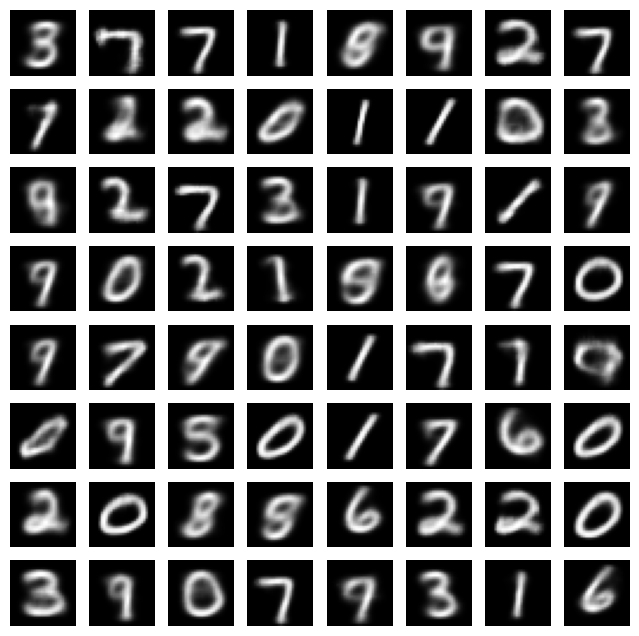

In [343]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [344]:
# encode and plot the z values for the train set 
arate_model.eval()
model.eval()

features2d = []
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, _, _ = model.half_pass(data)  
        arate = arate_model.forward(data)
        features2d.append(mu.cpu().numpy())
        firing_levels.append(np.max(arate.cpu().numpy(), axis=1))
        

features2d = np.concatenate(features2d, axis=0)
firing_levels = np.concatenate(firing_levels, axis=0)
#firing_levels = np.concatenate(firing_levels, axis=0)


Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

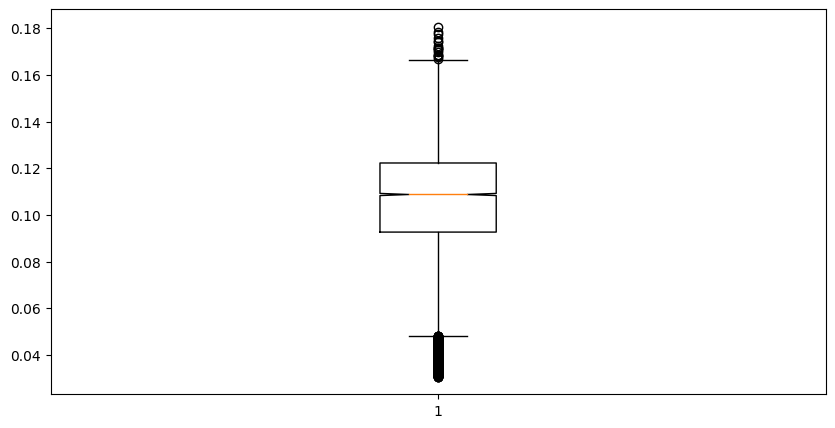

In [345]:
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [336]:
np.sum([np.abs(f-1) < 5e-1 for f in firing_levels])/len(firing_levels)


0.0

Text(0, 0.5, 'cvae 2')

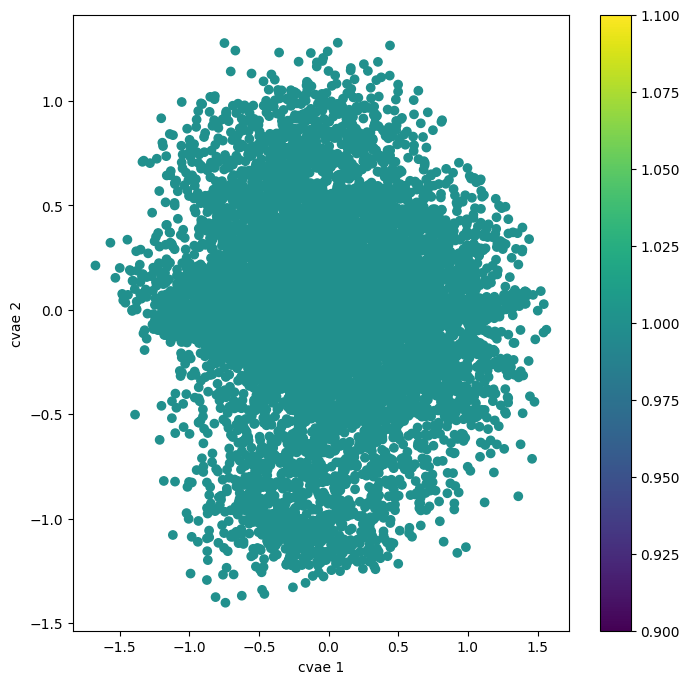

In [346]:


plt.figure(figsize=(8, 8))
plt.scatter(features2d[:, 0], features2d[:, 1], c=[(1 if np.abs(f) < 0.9 else 0) for f in firing_levels])
#centroids_inner = model.fuzzy.A[:,:,latent_dim].cpu().detach().numpy()
#plt.scatter(centroids_inner[:,0],centroids_inner[:,1], s=20, marker="+", c="green")
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

## EMNIST

In [347]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_14564\2657024364.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


In [348]:
arate_model.eval()

firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = arate_model.forward(data)

        for label, flabel in zip(labels, np.max(arate.cpu().numpy(), axis=1)):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

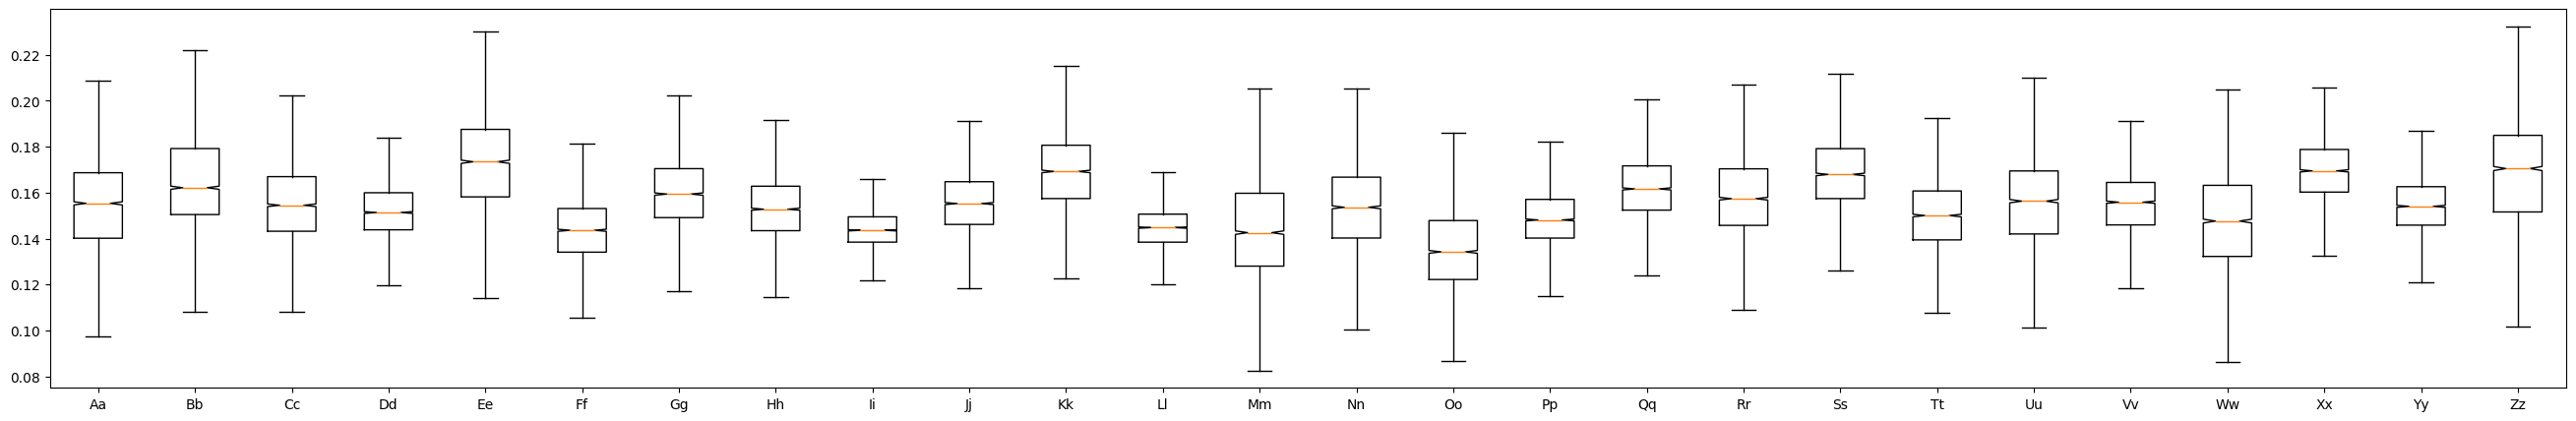

In [349]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

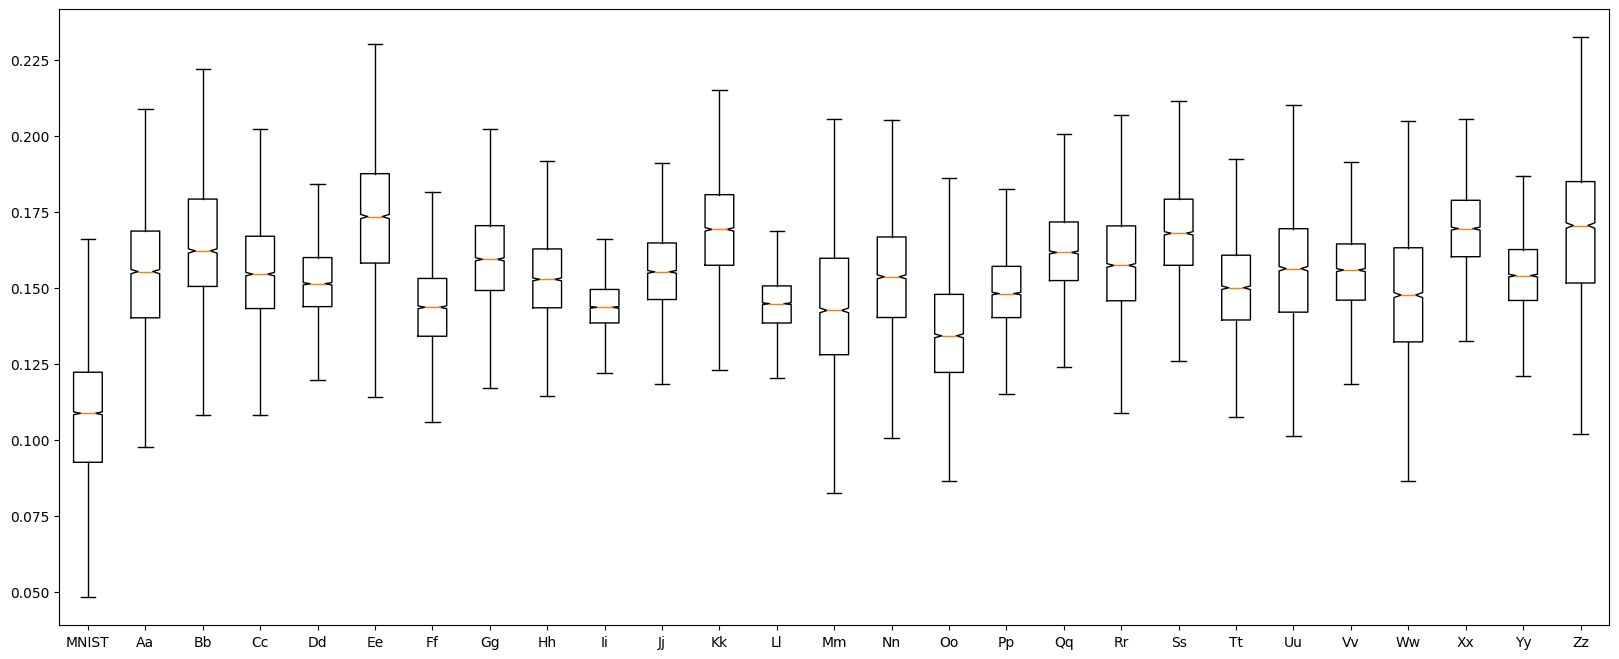

In [350]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(20, 8))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

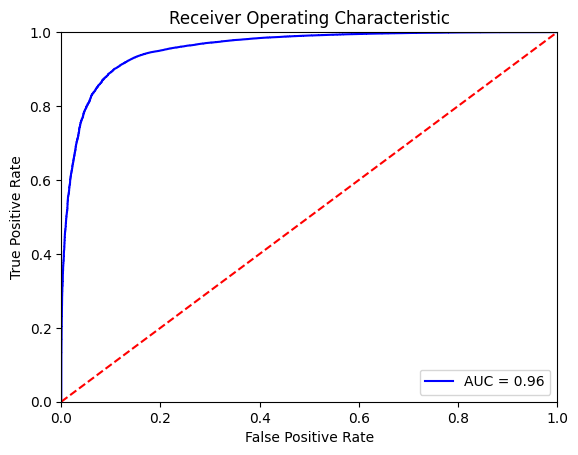

In [351]:
import sklearn.metrics as metrics

lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()